In [23]:
#Import packages and resources
import os
import sys
import json
import requests
import time
import datetime
import math
import pandas as pd
import numpy as np
import serial
import importlib
import matplotlib.pyplot as plt
import dash
import plotly.graph_objs as go
from functions.PitotProcess import PitotProcess
from functions.filtrar_datos_real_vert import filtrar_datos_vertical
from functions.V_Wind import V_Wind
from functions.Cb_e import C_b_e
from IPython.display import clear_output
from dash import dcc, html
from dash.dependencies import Output, Input


In [24]:
%reload_ext autoreload
%autoreload 2

**CONFIGURATION A REFERENCE SYSTEM CUBESAT SPACEPORT VOLTA**
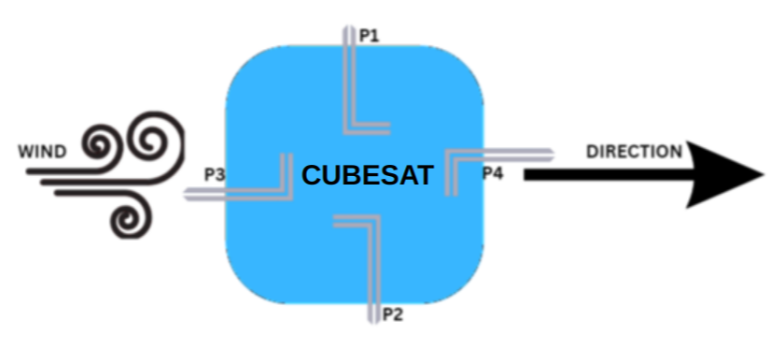

In [25]:
'''#LISTENING TO THE DATA
#Get the data from the ARDUINO BOARD
#seting up the serial connection
puerto = 'COM7' #'COM7'  
baudios = 9600  # Verifer in the Arduino IDE
timeout = 1  # time to wait for the data
#ser = serial.Serial(puerto, baudios, timeout=timeout)# WINDOS ONLY
arduino = serial.Serial(port='/dev/ttyS0', baudrate=9600, timeout=1)#LINUX ONLY'''

"#LISTENING TO THE DATA\n#Get the data from the ARDUINO BOARD\n#seting up the serial connection\npuerto = 'COM7' #'COM7'  \nbaudios = 9600  # Verifer in the Arduino IDE\ntimeout = 1  # time to wait for the data\n#ser = serial.Serial(puerto, baudios, timeout=timeout)# WINDOS ONLY\narduino = serial.Serial(port='/dev/ttyS0', baudrate=9600, timeout=1)#LINUX ONLY"

In [26]:
# Define the columns
column_names = ["P_1","P_2","P_3","P_4","T_1","T_2","T_3","T_4","phi","theta","psi","gpx_vx","gps_vy","gps_vz","coordinates_gps","IMU_vx","IMU_vy","IMU_vz","Timestamp"]

# Create an empty DataFrame
datos = pd.DataFrame(columns=column_names)

In [27]:
#DEFINE STATICAL CONDITIONS, OFFSET VALUES AND CONSTANTS
offset_pitots = [0, 0, 0, 0] #Pitot offset values
offset_IMU = [0, 0, 0] #IMU offset values
offset_GPS = [0, 0, 0] #GPS offset values
local_pressure = 101325 #Pa
R = 287.05 #J/(kg*K)
T = 273.15 #K
g = 9.81 #m/s^2
rho = 1.225 #kg/m^3

In [28]:

'''
# Inicializar la app de Dash
app = dash.Dash(__name__)
server = app.server

app.layout = html.Div([
    html.H1("Simulación de Vectores de Viento en Tiempo Real"),
    dcc.Graph(id='live-graph', style={'height': '70vh'}),
    dcc.Interval(
        id='interval-component',
        interval=500,  # Actualización cada 500 ms
        n_intervals=0
    ),
    html.Div(id='live-update-text')
])

@app.callback(
    [Output('live-graph', 'figure'),
     Output('live-update-text', 'children')],
    [Input('interval-component', 'n_intervals')]
)
def update_graph_live(n):
    global datos
    try:
        while True:
            if arduino.in_waiting > 0:
                raw_data = arduino.readline().decode('utf-8').strip()  # read the data from the arduino
                print(f"Data received: {raw_data}")
                
                # Split the data into a list of strings
                data_list = raw_data.split(',')
            
                # verify that the data is complete
                if len(data_list) == len(column_names):
                    # Convertir datos numéricos
                    try:
                        numeric_data = [pd.to_numeric(value, errors='coerce') for value in data_list]#convert to numeric
                        data_dict = dict(zip(column_names, numeric_data))#create a dictionary
                        datos = pd.concat([datos, pd.DataFrame([data_dict])], ignore_index=True)#add the data to the DataFrame
                        datos['Timestamp'] = pd.to_datetime(datos['Timestamp'], unit='s', errors='coerce')
                        datos = datos.iloc[-34:, :] 
                        if len(datos) >= 34:
                            
                            #show data in real time
                            pitots_data = numeric_data[0:4]
                            temp_data = numeric_data[4:8]
                            Eulerangle_data = numeric_data[8:11]
                            IMU_Vel_data = numeric_data[15:18]
                            GPS_Vel_data = numeric_data[11:14]
                            GPS_data = numeric_data[14]
                            
                            #IMU process 
                            euler_angles = [Eulerangle_data[0], Eulerangle_data[1], Eulerangle_data[2]] #NOTA: LA IMU DEBE PROPORCIONAR VALORES DE VELOCIDAD, REQUIERE FILTRO?
                            V_IMU = C_b_e(IMU_Vel_data, euler_angles)
                            imu_w = 0 #NOTA: THIS IS THE WEIGHT OF THE IMU IN THE MEASUREMENTS OF THE WIND SPEED, ALGOTITHM TO REGULATE SHOULD BE DEVELOPED
                            
                            #GPS process #NOTA_ el GPS debe proporcionar la velocidad en el sistema de coordenadas de la tierra y requiere filtro?
                            V_GPS = [GPS_Vel_data[0], GPS_Vel_data[1], GPS_Vel_data[2]]
                            gps_w = 0 #NOTA: THIS IS THE WEIGHT OF THE GPS IN THE MEASUREMENTS OF THE WIND SPEED, ALGOTITHM TO REGULATE SHOULD BE DEVELOPED
                            
                            #Pitot process
                            filtered_data, datos = filtrar_datos_vertical(pitots_data,datos[0:4], offset_pitots)
                            localtemp_pitot = temp_data.mean()#NOTA: ESTE VALOR LO ENTREGAN LOS PITOTS?
                            rho_prime = (local_pressure*0.02897)/(8.314472*(localtemp_pitot+273.15))
                            velocity_pitots = list(map(lambda x: ((2*abs(x)/rho_prime)**0.5), filtered_data))
                            proccessed_pitot_couples = PitotProcess(filtered_data,local_pressure,localtemp_pitot,euler_angles)

                            #TRANSFORM TO EARTH FRAME
                            V_wind = V_Wind(proccessed_pitot_couples,GPS_Vel_data, gps_w, V_IMU, imu_w)
                            V_Wind_earthsystem = C_b_e(V_wind, euler_angles)
                            datos.iloc[-1, :4] = filtered_data
                            # Mostrar resultados en tiempo real
                            clear_output(wait=True)
                            print(f"Pitots: {pitots_data} \n IMU: {Eulerangle_data} \n GPS_vel: {GPS_Vel_data} \n Viento en tierra: {V_Wind_earthsystem}")
                            # Graficar vectores
                            fig = go.Figure(data=[
                                go.Scatter3d(x=[0, GPS_Vel_data[0]], y=[0, GPS_Vel_data[1]], z=[0, GPS_Vel_data[2]],
                                            mode='lines+markers', name='GPS'),
                                go.Scatter3d(x=[0, IMU_Vel_data[0]], y=[0, IMU_Vel_data[1]], z=[0, IMU_Vel_data[2]],
                                            mode='lines+markers', name='IMU'),
                                go.Scatter3d(x=[0, proccessed_pitot_couples[0][0]], y=[0, proccessed_pitot_couples[0][1]], z=[0, proccessed_pitot_couples[0][2]],
                                            mode='lines+markers', name='Viento')
                            ])
                            fig.update_layout(
                                margin=dict(l=0, r=0, b=0, t=0),
                                scene=dict(
                                    xaxis_title='X',
                                    yaxis_title='Y',
                                    zaxis_title='Z'
                                )
                            )
                        time.sleep(0.5)  # Simular lectura en tiempo real
                        text = f"Pitots: {pitots_data} | Euler: {Eulerangle_data} | GPS: {GPS_Vel_data} | IMU: {IMU_Vel_data} | Viento: {viento.tolist()}"
                        return fig, text
                        
                    except ValueError:
                        print("Error converting DATA:", data_list)
                else:
                    print(f"Datos incompletos: {data_list}")
    
    except KeyboardInterrupt:
        print("Lectura finalizada.")
        arduino.close() 
# Ejecutar la app
if __name__ == '__main__':
    app.run_server(debug=True)'''


'\n# Inicializar la app de Dash\napp = dash.Dash(__name__)\nserver = app.server\n\napp.layout = html.Div([\n    html.H1("Simulación de Vectores de Viento en Tiempo Real"),\n    dcc.Graph(id=\'live-graph\', style={\'height\': \'70vh\'}),\n    dcc.Interval(\n        id=\'interval-component\',\n        interval=500,  # Actualización cada 500 ms\n        n_intervals=0\n    ),\n    html.Div(id=\'live-update-text\')\n])\n\n@app.callback(\n    [Output(\'live-graph\', \'figure\'),\n     Output(\'live-update-text\', \'children\')],\n    [Input(\'interval-component\', \'n_intervals\')]\n)\ndef update_graph_live(n):\n    global datos\n    try:\n        while True:\n            if arduino.in_waiting > 0:\n                raw_data = arduino.readline().decode(\'utf-8\').strip()  # read the data from the arduino\n                print(f"Data received: {raw_data}")\n                \n                # Split the data into a list of strings\n                data_list = raw_data.split(\',\')\n           

In [29]:
# Inicializar la app de Dash
app = dash.Dash(__name__)
server = app.server

app.layout = html.Div([
    html.H1("Simulación de Vectores de Viento en Tiempo Real"),
    dcc.Graph(id='live-graph', style={'height': '70vh'}),
    dcc.Interval(
        id='interval-component',
        interval=500,  # Actualización cada 500 ms
        n_intervals=0
    ),
    html.Div(id='live-update-text')
])

@app.callback(
    [Output('live-graph', 'figure'),
     Output('live-update-text', 'children')],
    [Input('interval-component', 'n_intervals')]
)
def update_graph_live(n):
    global datos
    try:
        offset_pitots = [0, 0, 0, 0]  # Offset ficticio para pitots
        local_pressure = 101325  # Presión atmosférica en Pascales
        rho = 1.225  # Densidad del aire a nivel del mar

        while True:
            # Generar datos ficticios coherentes
            pitots_data = np.random.uniform(0, 100, 4).tolist()
            temp_data = np.random.uniform(15, 30, 4).tolist()
            Eulerangle_data = np.random.uniform(-180, 180, 3).tolist()
            IMU_Vel_data = np.random.uniform(-5, 5, 3).tolist()
            GPS_Vel_data = np.random.uniform(-10, 10, 3).tolist()
            GPS_data = np.random.uniform(-90, 90)
            timestamp = time.time()

            # Crear el diccionario de datos
            data_dict = dict(zip(column_names, pitots_data + temp_data + Eulerangle_data + GPS_Vel_data + [GPS_data] + IMU_Vel_data + [timestamp]))
            datos = pd.concat([datos, pd.DataFrame([data_dict])], ignore_index=True)
            datos['Timestamp'] = pd.to_datetime(datos['Timestamp'], unit='s', errors='coerce')
            datos = datos.iloc[-34:, :]  # Mantener las últimas 34 fil

            if len(datos) == 34:
                # Procesar datos simulados
                euler_angles = Eulerangle_data
                V_IMU = C_b_e(IMU_Vel_data, euler_angles)
                imu_w = 0.4  # Peso ficticio para IMU
                gps_w = 0.5  # Peso ficticio para GPS
            
                # Filtrar datos pitots y calcular velocidades
                filtered_data, datos = filtrar_datos_vertical(pitots_data, datos.iloc[:, :4], offset_pitots)
                localtemp_pitot = np.mean(temp_data)
                rho_prime = (local_pressure * 0.02897) / (8.314472 * (localtemp_pitot + 273.15))
                velocity_pitots = np.sqrt(2 * np.abs(filtered_data) / rho_prime)
                proccessed_pitot_couples = np.array(PitotProcess(filtered_data, local_pressure, localtemp_pitot, euler_angles))

                V_wind = V_Wind(proccessed_pitot_couples, GPS_Vel_data, gps_w, V_IMU, imu_w)
                V_Wind_earthsystem = C_b_e(V_wind, euler_angles)

                datos.iloc[-1, :4] = filtered_data
                # Mostrar resultados en tiempo real
                clear_output(wait=True)
                # Graficar vectores
                fig = go.Figure(data=[
                    go.Scatter3d(x=[0, GPS_Vel_data[0]], y=[0, GPS_Vel_data[1]], z=[0, GPS_Vel_data[2]],
                                mode='lines+markers', name='GPS'),
                    go.Scatter3d(x=[0, IMU_Vel_data[0]], y=[0, IMU_Vel_data[1]], z=[0, IMU_Vel_data[2]],
                                mode='lines+markers', name='IMU'),
                    go.Scatter3d(x=[0, proccessed_pitot_couples[0][0]], y=[0, proccessed_pitot_couples[0][1]], z=[0, proccessed_pitot_couples[0][2]],
                                mode='lines+markers', name='Viento')
                ])
                fig.update_layout(
                    margin=dict(l=0, r=0, b=0, t=0),
                    scene=dict(
                        xaxis_title='X',
                        yaxis_title='Y',
                        zaxis_title='Z'
                    )
                )
                text = f"Pitots: {pitots_data} | Euler: {Eulerangle_data} | GPS: {GPS_Vel_data} | IMU: {IMU_Vel_data} | Viento: {V_wind.tolist()}"
                return fig, text
            time.sleep(0.5)
    except KeyboardInterrupt:
        print("Simulación finalizada.")
# Ejecutar la app
if __name__ == '__main__':
    app.run_server(debug=True)


In [33]:
import dash
from dash import dcc, html
from dash.dependencies import Output, Input
import plotly.graph_objs as go
import numpy as np
import time

# Inicializar la app Dash
app = dash.Dash(__name__)

# Configurar diseño inicial de la visualización
app.layout = html.Div([
    html.H1("Simulación de Viento Impactando un Satélite"),
    dcc.Graph(id='cubo-simulacion'),
    dcc.Interval(
        id='interval-component',
        interval=5000,  # Actualizar cada 500 ms
        n_intervals=0
    )
])

# Generar datos aleatorios de viento y movimiento
@app.callback(
    Output('cubo-simulacion', 'figure'),
    Input('interval-component', 'n_intervals')
)
def actualizar_grafico(n):
    # Datos simulados de viento y movimiento
    viento = np.random.uniform(-5, 5, 3)  # Viento en X, Y, Z
    velocidad = np.random.uniform(-2, 2, 3)  # Movimiento del cuerpo

    # Definir el cubo
    x = [0, 1, 1, 0, 0, 1, 1, 0]
    y = [0, 0, 1, 1, 0, 0, 1, 1]
    z = [0, 0, 0, 0, 1, 1, 1, 1]

    # Crear el cubo 3D
    cubo = go.Mesh3d(
        x=x,
        y=y,
        z=z,
        color='lightblue',
        opacity=0.50
    )

    # Vectores de viento
    viento_vector = go.Cone(
        x=[0.5],
        y=[0.5],
        z=[0.5],
        u=[viento[0]],
        v=[viento[1]],
        w=[viento[2]],
        sizemode="scaled",
        sizeref=0.5,
        colorscale='Reds',
        showscale=True
    )

    # Movimiento del cuerpo
    velocidad_vector = go.Cone(
        x=[0.5],
        y=[0.5],
        z=[0.5],
        u=[velocidad[0]],
        v=[velocidad[1]],
        w=[velocidad[2]],
        sizemode="scaled",
        sizeref=0.5,
        colorscale='Blues',
        showscale=True
    )

    # Configurar la figura
    fig = go.Figure(data=[cubo, viento_vector, velocidad_vector])
    fig.update_layout(
        scene=dict(
            xaxis=dict(range=[-5, 5]),
            yaxis=dict(range=[-5, 5]),
            zaxis=dict(range=[-5, 5])
        ),
        title="Impacto de Viento y Movimiento en un Satélite"
    )
    return fig

# Ejecutar la app
if __name__ == '__main__':
    app.run_server(debug=True)